In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ase import io
import plumed
import shutil
import os

In [2]:
# This creates the directory we run MD within
!rm -rf ../Trajectories && mkdir ../Trajectories

# Some helper functions

I have defined these functions to help me setup and run calculations using PLUMED from this python notebook 

In [3]:
def setup_plumed( file ) : 
    # Read in trajectory using ase
    traj = io.read(file,':')
    # Setup plumed object to do calculation
    p = plumed.Plumed()
    p.cmd("setMDEngine","python")
    # Read PDB so units are 0.1 nm
    p.cmd("setMDLengthUnits", 0.1)
    p.cmd("setTimestep", 1.)
    p.cmd("setKbT", 1.)
    natoms = len(traj[0].positions)
    p.cmd("setNatoms",natoms)
    p.cmd("setLogFile","test.log")
    p.cmd("init")
    return p, traj

def plumed_step( p, ts ) :
    pos = np.array(ts.get_positions(), dtype=np.float64 )
    natoms, box = len(pos), np.array([[100.,0,0],[0,100.,0],[0,0,100]])
    p.cmd("setStep",nfram)
    p.cmd("setBox",box )
    p.cmd("setMasses", ts.get_masses() )
    charges = np.zeros(natoms,dtype=np.float64)
    p.cmd("setCharges", charges )  
    p.cmd("setPositions", pos )
    forces = np.zeros([natoms,3])
    p.cmd("setForces", forces )
    virial = np.zeros((3,3),dtype=np.float64)
    p.cmd("setVirial", virial )
    p.cmd("calc")
    return 
    
def create_plumed_var( p, name, command ):
    p.cmd("readInputLine", name + ": " + command )
    shape = np.zeros( 1, dtype=np.int_ )
    p.cmd("getDataRank " + name, shape )
    data = np.zeros((1))
    p.cmd("setMemoryForData " + name, data )
    return data 

And another helper function to help me run gromacs

In [4]:
def generate_gromacs_input( directory, plumed_input, nsteps, temp ) :
    # Setup the initial configuration by picking a frame at random from the startpoints file
    allc = io.read('../data/startpoints.pdb',':')
    nframes = len(allc)
    io.write( directory + '/conf.pdb', allc[int(np.random.randint(0,nframes))] )
    # Copy the topology to the appropriate directory
    shutil.copyfile("../data/topol.top", directory + "/topol.top")
    # Setup the mdp file
    mdp = open("../data/md.mdp","r")
    contents = mdp.read()
    mdp.close()
    new_content = contents.replace("SEED", str(np.random.randint(0,1000000))).replace("NSTEPS",str(nsteps)).replace("TEMP",str(temp)) 
    mdpout = open(directory + "/md.mdp", "w")
    mdpout.write(new_content)
    mdpout.close()
    # And write the plumed input
    pout = open(directory + "/plumed.dat", "w")
    pout.write( plumed_input )
    pout.close()
    return

## First exercise: Calculating phi and psi along transition path

The following cell uses the helper function above to apply PLUMED to calculate the values of $\phi$ and $\psi$ as we move along the transition path that connects the two states:

In [5]:
# Read plumed input
p, traj = setup_plumed('../data/alanine-transformation.pdb')
phi = create_plumed_var( p, "phi", "TORSION ATOMS=5,7,9,15")
psi = create_plumed_var( p, "psi", "TORSION ATOMS=7,9,15,17")

# Loop over trajectory and get data from plumed
nfram, tt, phiv, psiv = 0, [], [], [] 
for ts in traj :
    plumed_step( p, ts )
    tt.append(nfram)
    phiv.append(phi[0])
    psiv.append(psi[0])
    nfram = nfram + 1

Lets now make some graphs of how these angles change as a function of time:

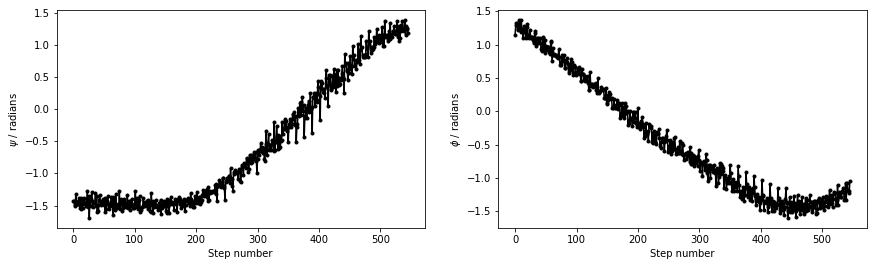

In [10]:
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.subplots_adjust(right=2)
ax1.plot( tt, phiv, 'k.' )
ax1.plot( tt, phiv, 'k-' )
ax1.set_xlabel("Step number")
ax1.set_ylabel(r"$\psi$ / radians")

ax2.plot( tt, psiv, 'k.' )
ax2.plot( tt, psiv, 'k-' )
ax2.set_xlabel("Step number")
ax2.set_ylabel(r"$\phi$ / radians")

#plt.savefig("masterclass-21-6-rama-transition.png", bbox_inches='tight')
plt.show()

# The curse of dimensionality

First lets run a high and low temperature simulations to generate some data to analyse

In [12]:
plm = '''
phi: TORSION ATOMS=5,7,9,15
psi: TORSION ATOMS=7,9,15,17
c7ax: RMSD REFERENCE=../../data/C7ax.pdb TYPE=OPTIMAL
c7eq: RMSD REFERENCE=../../data/C7eq.pdb TYPE=OPTIMAL
PRINT ARG=phi,psi,c7ax,c7eq FILE=colvar STRIDE=100'''

# This is the low temperature simulation 

# Create a directory to run the calculation in
!rm -rf ../Trajectories/RMSD_300K && mkdir ../Trajectories/RMSD_300K
# Generate gromacs input
generate_gromacs_input( '../Trajectories/RMSD_300K', plm, 500000, 300 )
# Now run gromacs
!cd ../Trajectories/RMSD_300K/ && gmx_mpi grompp -f md.mdp -c conf.pdb -p topol.top -maxwarn 2 &> /dev/null
!cd ../Trajectories/RMSD_300K/ && gmx_mpi mdrun --plumed plumed.dat &> /dev/null
# And read in the colvar files
lowT_data = np.loadtxt('../Trajectories/RMSD_300K/colvar')

# And this is the high temperature simulation

# Create a directory to run the calculation in
!rm -rf ../Trajectories/RMSD_1000K && mkdir ../Trajectories/RMSD_1000K
# Generate gromacs input
generate_gromacs_input( '../Trajectories/RMSD_1000K', plm, 500000, 1000 )
# Now run gromacs
!cd ../Trajectories/RMSD_1000K/ && gmx_mpi grompp -f md.mdp -c conf.pdb -p topol.top -maxwarn 2 &> /dev/null
!cd ../Trajectories/RMSD_1000K/ && gmx_mpi mdrun --plumed plumed.dat &> /dev/null
# And read in the colvar files
highT_data = np.loadtxt('../Trajectories/RMSD_1000K/colvar')

Lets analyse the data in alanine-transformation.pdb using these coordinates

In [13]:
# Read the plumed input
p, traj = setup_plumed('../data/alanine-transformation.pdb')
# Setup PLUMED
ax = create_plumed_var( p, "c7ax", "RMSD REFERENCE=../data/C7ax.pdb TYPE=OPTIMAL")
eq = create_plumed_var( p, "c7eq", "RMSD REFERENCE=../data/C7eq.pdb TYPE=OPTIMAL")

# Loop over trajectory and get data from plumed
nfram, c7axv, c7eqv = 0, [], []
for ts in traj :
    plumed_step( p, ts )
    c7axv.append(ax[0])
    c7eqv.append(eq[0])
    nfram = nfram + 1

And now we will create the plot

[]

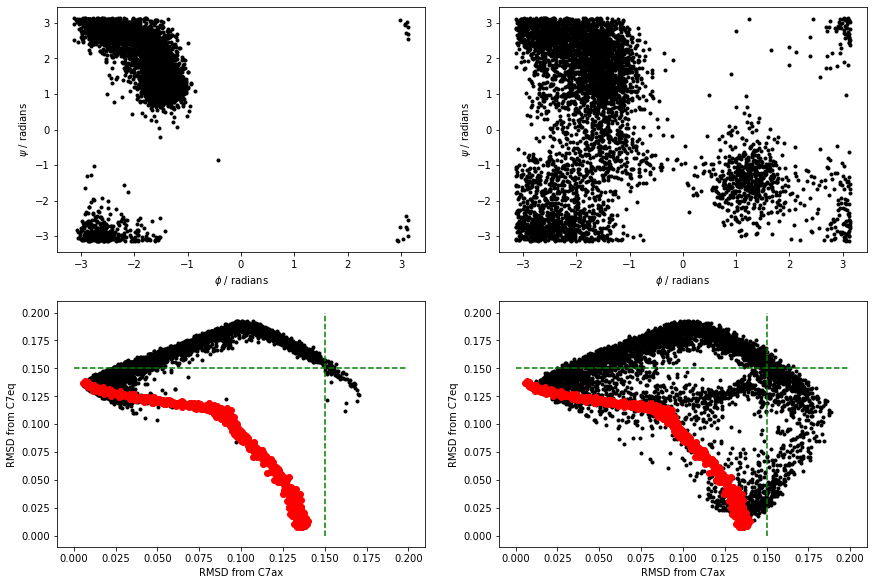

In [16]:
fig, ax = plt.subplots( 2, 2 )
plt.subplots_adjust( right=2, top=2  )
ax[0,0].plot( lowT_data[:,1], lowT_data[:,2], 'k.' )
ax[0,0].set_xlabel(r"$\phi$ / radians")
ax[0,0].set_ylabel(r"$\psi$ / radians")
ax[1,0].plot( lowT_data[:,3], lowT_data[:,4], 'k.' ) 
ax[1,0].plot( c7axv, c7eqv, 'ro' )
ax[1,0].set_xlabel("RMSD from C7ax")
ax[1,0].plot( [0.15,0.15], [0,0.2], 'g--')
ax[1,0].plot( [0,0.2], [0.15,0.15], 'g--')
ax[1,0].set_ylabel("RMSD from C7eq")
ax[0,1].plot( highT_data[:,1], highT_data[:,2], 'k.' ) 
ax[0,1].set_xlabel(r"$\phi$ / radians")
ax[0,1].set_ylabel(r"$\psi$ / radians")
ax[1,1].plot( highT_data[:,3], highT_data[:,4], 'k.' ) 
ax[1,1].plot( c7axv, c7eqv, 'ro' )
ax[1,1].set_xlabel("RMSD from C7ax")
ax[1,1].plot( [0.15,0.15], [0,0.2], 'g--')
ax[1,1].plot( [0,0.2], [0.15,0.15], 'g--')
ax[1,1].set_ylabel("RMSD from C7eq")
#plt.savefig("masterclass-21-6-rmsd-distances.png", bbox_inches='tight' )
plt.plot()

# Using dot products to calculate CVs

Lets first calculate a unit vector that points from the C7ax state to the C7eq state.  Here I am using the data on $\phi$ and $\psi$ from the initial and final configurations in alanine-transformation.pdb that I calculated above.

In [17]:
diff1 = phiv[len(phiv)-1]- phiv[0]
diff2 = psiv[len(psiv)-1]-psiv[0]
mod = np.sqrt( diff1*diff1 + diff2*diff2 )
print( "PARAMETERS ARE", phiv[0], psiv[0] )
print( "COEFFICIENTS ARE", diff1/mod, diff2/mod )

PARAMETERS ARE -1.4248085245914177 1.1457778525511566
COEFFICIENTS ARE 0.7656151065134918 -0.6432989263774146


Lets calculate how the projection on this vector changes as we go through the transition. 

In [18]:
# Read plumed input
p, traj = setup_plumed('../data/alanine-transformation.pdb')
p.cmd("readInputLine", "phi: TORSION ATOMS=5,7,9,15")
p.cmd("readInputLine", "psi: TORSION ATOMS=7,9,15,17")
p.cmd("readInputLine", "pca: COMBINE ARG=phi,psi PERIODIC=NO" \
      " COEFFICIENTS=" + str(diff1/mod) + "," + str(diff2/mod) + \
      " PARAMETERS=" + str(phiv[0]) + "," + str(psiv[0]) )
shape = np.zeros( 1, dtype=np.int_ )
p.cmd("getDataRank pca", shape )
data = np.zeros((1))
p.cmd("setMemoryForData pca",data )

# Loop over trajectory and get data from plumed
nfram, tt, pca = 0, [], []
for ts in traj :
    plumed_step( p, ts )
    tt.append(1.8*nfram)
    pca.append(data[0])
    nfram = nfram + 1

And lets also run some MD

In [19]:
plm = '''
phi: TORSION ATOMS=5,7,9,15
psi: TORSION ATOMS=7,9,15,17'''

plm = plm + "\n pca: COMBINE ARG=phi,psi PERIODIC=NO" \
      " COEFFICIENTS=" + str(diff1/mod) + "," + str(diff2/mod) + \
      " PARAMETERS=" + str(phiv[0]) + "," + str(psiv[0]) + \
"\n PRINT ARG=phi,psi,pca FILE=colvar STRIDE=100"

# This is the low temperature simulation 

# Create a directory to run the calculation in
!rm -rf ../Trajectories/LDProj_300K && mkdir ../Trajectories/LDProj_300K
# Generate gromacs input
generate_gromacs_input( '../Trajectories/LDProj_300K', plm, 500000, 300 )
# Now run gromacs
!cd ../Trajectories/LDProj_300K/ && gmx_mpi grompp -f md.mdp -c conf.pdb -p topol.top -maxwarn 2 &> /dev/null
!cd ../Trajectories/LDProj_300K/ && gmx_mpi mdrun --plumed plumed.dat &> /dev/null
# And read in the colvar files
lowT_data = np.loadtxt('../Trajectories/LDProj_300K/colvar')

# And this is the high temperature simulation

# Create a directory to run the calculation in
!rm -rf ../Trajectories/LDProj_1000K && mkdir ../Trajectories/LDProj_1000K
# Generate gromacs input
generate_gromacs_input( '../Trajectories/LDProj_1000K', plm, 500000, 1000 )
# Now run gromacs
!cd ../Trajectories/LDProj_1000K/ && gmx_mpi grompp -f md.mdp -c conf.pdb -p topol.top -maxwarn 2 &> /dev/null
!cd ../Trajectories/LDProj_1000K/ && gmx_mpi mdrun --plumed plumed.dat &> /dev/null
# And read in the colvar files
highT_data = np.loadtxt('../Trajectories/LDProj_1000K/colvar')

 And lets make our graph

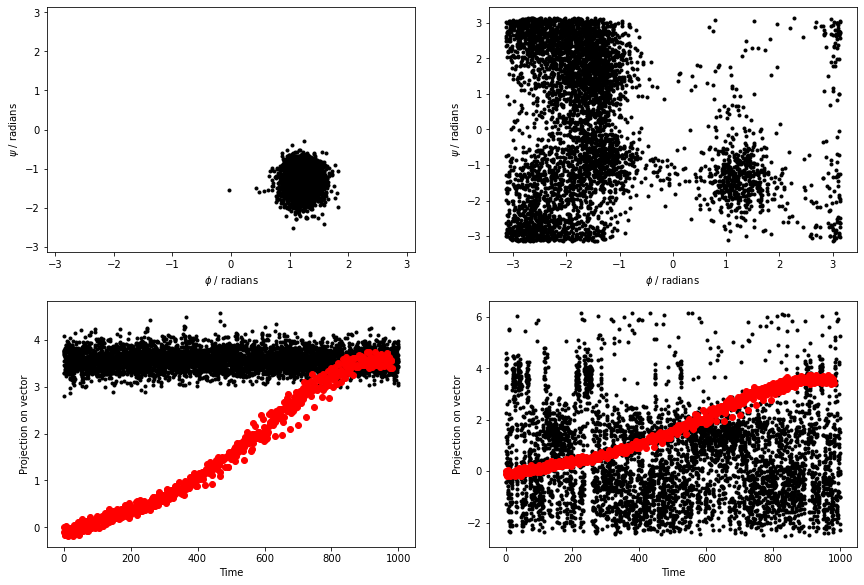

In [22]:
fig, ax = plt.subplots( 2, 2 )
plt.subplots_adjust( right=2, top=2  )
ax[0,0].plot( lowT_data[:,1], lowT_data[:,2], 'k.' )
ax[0,0].set_xlim([-np.pi,np.pi])
ax[0,0].set_ylim([-np.pi,np.pi])
ax[0,0].set_xlabel(r"$\phi$ / radians")
ax[0,0].set_ylabel(r"$\psi$ / radians")
ax[1,0].plot( lowT_data[:,0], lowT_data[:,3], 'k.' ) 
ax[1,0].plot( tt, pca, 'ro' )
ax[1,0].set_xlabel("Time")
ax[1,0].set_ylabel("Projection on vector")
ax[0,1].plot( highT_data[:,1], highT_data[:,2], 'k.' ) 
ax[0,1].set_xlabel(r"$\phi$ / radians")
ax[0,1].set_ylabel(r"$\psi$ / radians")
ax[1,1].plot( highT_data[:,0], highT_data[:,3], 'k.' ) 
ax[1,1].plot( tt, pca, 'ro' )
ax[1,1].set_xlabel("Time")
ax[1,1].set_ylabel("Projection on vector")
#plt.savefig("masterclass-21-6-pcavars-transition.png", bbox_inches='tight')
plt.plot()

# PCA Collective variables

In the cell below I have analysed the alanine-transformation using the PCAVARS.

In [23]:
# Read plumed input
p, traj = setup_plumed('../data/alanine-transformation.pdb')
p.cmd("readInputLine", "pca: PCAVARS REFERENCE=../data/pca-reference.pdb TYPE=OPTIMAL")
shape = np.zeros( 1, dtype=np.int_ )
p.cmd("getDataRank pca.eig-1", shape )
data1 = np.zeros((1))
p.cmd("setMemoryForData pca.eig-1", data1 )
p.cmd("getDataRank pca.residual", shape )
data2 = np.zeros((1))
p.cmd("setMemoryForData pca.residual", data2 )

# Loop over trajectory and get data from plumed
nfram, tt, pca, res= 0, [], [], []
for ts in traj :
    plumed_step( p, ts )
    tt.append(nfram)
    pca.append(data1[0])
    res.append(data2[0])
    nfram = nfram + 1

Now some MD at high and low temperature monitoring these CVs

In [24]:
plm = '''
phi: TORSION ATOMS=5,7,9,15
psi: TORSION ATOMS=7,9,15,17
pca: PCAVARS REFERENCE=../../data/pca-reference.pdb TYPE=OPTIMAL
PRINT ARG=phi,psi,pca.* FILE=colvar STRIDE=100
'''

# This is the low temperature simulation 

# Create a directory to run the calculation in
!rm -rf ../Trajectories/PCA_300K && mkdir ../Trajectories/PCA_300K
# Generate gromacs input
generate_gromacs_input( '../Trajectories/PCA_300K', plm, 500000, 300 )
# Now run gromacs
!cd ../Trajectories/PCA_300K/ && gmx_mpi grompp -f md.mdp -c conf.pdb -p topol.top -maxwarn 2 &> /dev/null
!cd ../Trajectories/PCA_300K/ && gmx_mpi mdrun --plumed plumed.dat &> /dev/null
# And read in the colvar files
lowT_data = np.loadtxt('../Trajectories/PCA_300K/colvar')

# And this is the high temperature simulation

# Create a directory to run the calculation in
!rm -rf ../Trajectories/PCA_1000K && mkdir ../Trajectories/PCA_1000K
# Generate gromacs input
generate_gromacs_input( '../Trajectories/PCA_1000K', plm, 500000, 1000 )
# Now run gromacs
!cd ../Trajectories/PCA_1000K/ && gmx_mpi grompp -f md.mdp -c conf.pdb -p topol.top -maxwarn 2 &> /dev/null
!cd ../Trajectories/PCA_1000K/ && gmx_mpi mdrun --plumed plumed.dat &> /dev/null
# And read in the colvar files
highT_data = np.loadtxt('../Trajectories/PCA_1000K/colvar')

Now plot all this data we have generated

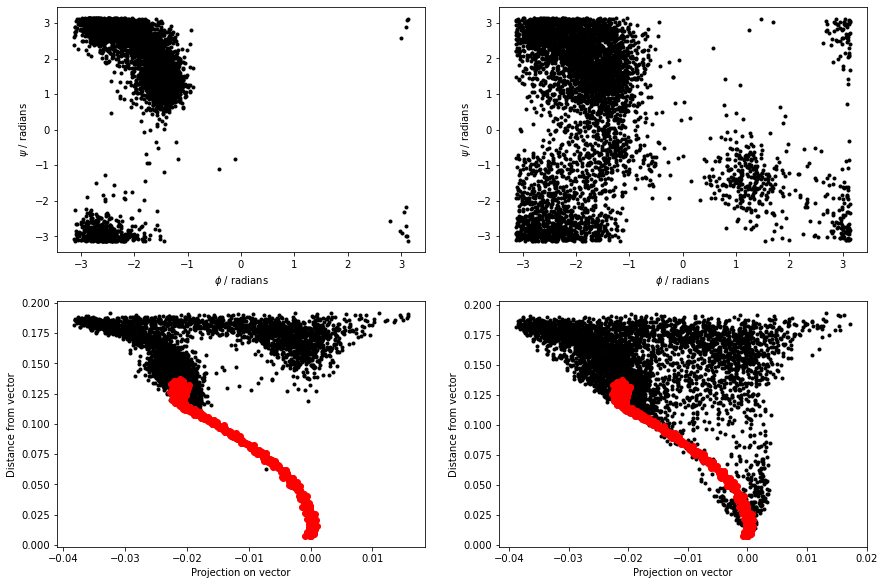

In [26]:
fig, ax = plt.subplots( 2, 2 )
plt.subplots_adjust( right=2, top=2  )
ax[0,0].plot( lowT_data[:,1], lowT_data[:,2], 'k.' )
ax[0,0].set_xlabel(r"$\phi$ / radians")
ax[0,0].set_ylabel(r"$\psi$ / radians")
ax[1,0].plot( lowT_data[:,3], lowT_data[:,4], 'k.' ) 
ax[1,0].plot( pca, res, 'ro' )
ax[1,0].set_xlabel("Projection on vector")
ax[1,0].set_ylabel("Distance from vector")
ax[0,1].plot( highT_data[:,1], highT_data[:,2], 'k.' ) 
ax[0,1].set_xlabel(r"$\phi$ / radians")
ax[0,1].set_ylabel(r"$\psi$ / radians")
ax[1,1].plot( highT_data[:,3], highT_data[:,4], 'k.' ) 
ax[1,1].plot( pca, res, 'ro' )
ax[1,1].set_xlabel("Projection on vector")
ax[1,1].set_ylabel("Distance from vector")
#plt.savefig("masterclass-21-6-pcavars.png", bbox_inches='tight')
plt.plot()

# Two PCA Collective variables

The cell below contains a function that can generate input for gromacs so that we can run simulations from this notebook.  This is the function that you were given in the description of the exercise:

In [27]:
 # Read plumed input
p, traj = setup_plumed('../data/alanine-transformation.pdb')
p.cmd("readInputLine", "pca: PCAVARS REFERENCE=../data/pca2-reference.pdb TYPE=OPTIMAL")
shape = np.zeros( 1, dtype=np.int_ )
p.cmd("getDataRank pca.eig-1", shape )
data1 = np.zeros((1))
p.cmd("setMemoryForData pca.eig-1", data1 )
p.cmd("getDataRank pca.eig-2", shape )
data2 = np.zeros((1))
p.cmd("setMemoryForData pca.eig-2", data2 )

# Loop over trajectory and get data from plumed
nfram, tt, pca1, pca2= 0, [], [], []
for ts in traj :
    plumed_step( p, ts )
    tt.append(nfram)
    pca1.append(data1[0])
    pca2.append(data2[0])
    nfram = nfram + 1

Calculate torsions for frames in reference configurations (notice different atom numbers here as there are fewer atoms in these PDB files).

In [28]:
# Read plumed input
p, traj = setup_plumed('../data/pca2-reference.pdb')
phi = create_plumed_var( p, "phi", "TORSION ATOMS=2,4,6,9")
psi = create_plumed_var( p, "psi", "TORSION ATOMS=4,6,9,11")

# Loop over trajectory and get data from plumed
nfram, tt, phiv2, psiv2 = 0, [], [], [] 
for ts in traj :
    plumed_step( p, ts )
    tt.append(nfram)
    phiv2.append(phi[0])
    psiv2.append(psi[0])
    nfram = nfram + 1

Now run MD at low and high temperature

In [31]:
plm = '''
phi: TORSION ATOMS=5,7,9,15
psi: TORSION ATOMS=7,9,15,17
pca: PCAVARS REFERENCE=../../data/pca2-reference.pdb TYPE=OPTIMAL
PRINT ARG=phi,psi,pca.* FILE=colvar STRIDE=100
'''

# This is the low temperature simulation 

# Create a directory to run the calculation in
!rm -rf ../Trajectories/PCA2_300K && mkdir ../Trajectories/PCA2_300K
# Generate gromacs input
generate_gromacs_input( '../Trajectories/PCA2_300K', plm, 500000, 300 )
# Now run gromacs
!cd ../Trajectories/PCA2_300K/ && gmx_mpi grompp -f md.mdp -c conf.pdb -p topol.top -maxwarn 2 &> /dev/null
!cd ../Trajectories/PCA2_300K/ && gmx_mpi mdrun --plumed plumed.dat &> /dev/null
# And read in the colvar files
lowT_data = np.loadtxt('../Trajectories/PCA2_300K/colvar')

# And this is the high temperature simulation

# Create a directory to run the calculation in
!rm -rf ../Trajectories/PCA2_1000K && mkdir ../Trajectories/PCA2_1000K
# Generate gromacs input
generate_gromacs_input( '../Trajectories/PCA2_1000K', plm, 500000, 1000 )
# Now run gromacs
!cd ../Trajectories/PCA2_1000K/ && gmx_mpi grompp -f md.mdp -c conf.pdb -p topol.top -maxwarn 2 &> /dev/null
!cd ../Trajectories/PCA2_1000K/ && gmx_mpi mdrun --plumed plumed.dat &> /dev/null
# And read in the colvar files
highT_data = np.loadtxt('../Trajectories/PCA2_1000K/colvar')

And make some plots

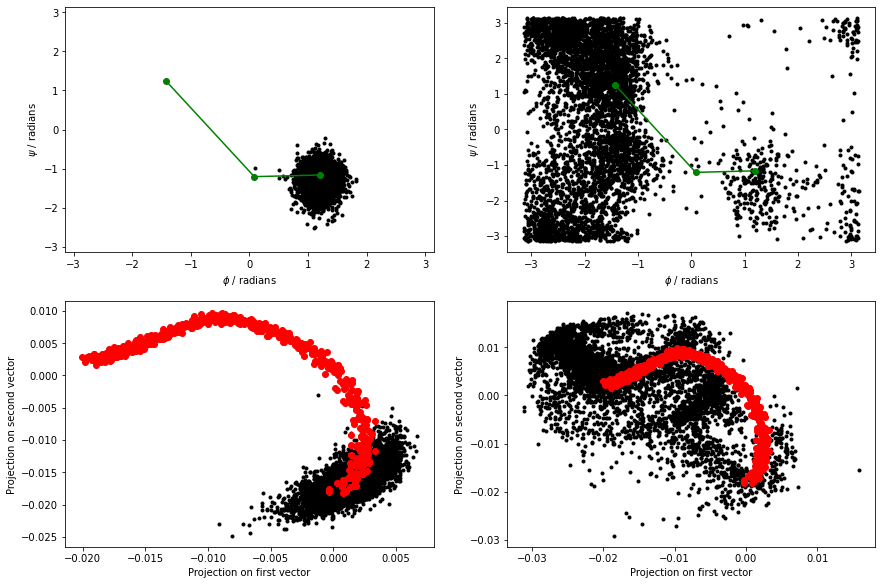

In [35]:
fig, ax = plt.subplots( 2, 2 )
plt.subplots_adjust( right=2, top=2  )
ax[0,0].plot( lowT_data[:,1], lowT_data[:,2], 'k.' )
ax[0,0].plot( phiv2, psiv2, 'go' )
ax[0,0].plot( [phiv2[0],phiv2[1]], [psiv2[0],psiv2[1]], 'g-' )
ax[0,0].plot( [phiv2[0],phiv2[2]], [psiv2[0],psiv2[2]], 'g-' )
ax[0,0].set_xlabel(r"$\phi$ / radians")
ax[0,0].set_ylabel(r"$\psi$ / radians")
ax[0,0].set_xlim([-np.pi,np.pi])
ax[0,0].set_ylim([-np.pi,np.pi])
ax[1,0].plot( lowT_data[:,3], lowT_data[:,4], 'k.' ) 
ax[1,0].plot( pca1, pca2, 'ro' )
ax[1,0].set_xlabel("Projection on first vector")
ax[1,0].set_ylabel("Projection on second vector")
ax[0,1].plot( highT_data[:,1], highT_data[:,2], 'k.' ) 
ax[0,1].plot( phiv2, psiv2, 'go' )
ax[0,1].plot( [phiv2[0],phiv2[1]], [psiv2[0],psiv2[1]], 'g-' )
ax[0,1].plot( [phiv2[0],phiv2[2]], [psiv2[0],psiv2[2]], 'g-' )
ax[0,1].set_xlabel(r"$\phi$ / radians")
ax[0,1].set_ylabel(r"$\psi$ / radians")
ax[1,1].plot( highT_data[:,3], highT_data[:,4], 'k.' ) 
ax[1,1].plot( pca1, pca2, 'ro' )
ax[1,1].set_xlabel("Projection on first vector")
ax[1,1].set_ylabel("Projection on second vector")
plt.savefig("masterclass-21-6-pcavars2.png", bbox_inches='tight')
#plt.plot()

# Path collective variables

We run our unbiased MD simulation using the script below:

In [36]:
plm = '''
phi: TORSION ATOMS=5,7,9,15
psi: TORSION ATOMS=7,9,15,17
path: PATH REFERENCE=../../data/alanine-path.pdb TYPE=OPTIMAL LAMBDA=15100.
PRINT ARG=phi,psi,path.* FILE=colvar STRIDE=100'''

# This is the low temperature simulation 

# Create a directory to run the calculation in
!rm -rf ../Trajectories/Path_300K && mkdir ../Trajectories/Path_300K
# Generate gromacs input
generate_gromacs_input( '../Trajectories/Path_300K', plm, 500000, 300 )
# Now run gromacs
!cd ../Trajectories/Path_300K/ && gmx_mpi grompp -f md.mdp -c conf.pdb -p topol.top -maxwarn 2 &> /dev/null
!cd ../Trajectories/Path_300K/ && gmx_mpi mdrun --plumed plumed.dat &> /dev/null
# And read in the colvar files
lowT_data = np.loadtxt('../Trajectories/Path_300K/colvar')

# And this is the high temperature simulation

# Create a directory to run the calculation in
!rm -rf ../Trajectories/Path_1000K && mkdir ../Trajectories/Path_1000K
# Generate gromacs input
generate_gromacs_input( '../Trajectories/Path_1000K', plm, 500000, 1000 )
# Now run gromacs
!cd ../Trajectories/Path_1000K/ && gmx_mpi grompp -f md.mdp -c conf.pdb -p topol.top -maxwarn 2 &> /dev/null
!cd ../Trajectories/Path_1000K/ && gmx_mpi mdrun --plumed plumed.dat &> /dev/null
# And read in the colvar files
highT_data = np.loadtxt('../Trajectories/Path_1000K/colvar')

Lets now calculate $\phi$, $\psi$ and the path CVs for the configurations in  alanine-transformation.pdb

In [37]:
# Read the plumed input
p, traj = setup_plumed('../data/alanine-transformation.pdb')
# Setup PLUMED
ax = create_plumed_var( p, "phi", "TORSION ATOMS=5,7,9,15")
eq = create_plumed_var( p, "psi", "TORSION ATOMS=7,9,15,17")
p.cmd("readInputLine", "path: PATH REFERENCE=../data/alanine-path.pdb TYPE=OPTIMAL LAMBDA=15100.")
shape = np.zeros( 1, dtype=np.int_ )
p.cmd("getDataRank path.spath", shape )
s = np.zeros((1))
p.cmd("setMemoryForData path.spath", s )
p.cmd("getDataRank path.zpath", shape )
z = np.zeros((1))
p.cmd("setMemoryForData path.zpath", z )

# Loop over trajectory and get data from plumed
nfram, phiv, psiv, svals, zvals = 0, [], [], [], []
for ts in traj :
    plumed_step( p, ts )
    phiv.append(ax[0])
    psiv.append(eq[0])
    svals.append(s[0])
    zvals.append(z[0])
    nfram = nfram + 1

Calculate torsions for frames in path (notice different atom numbers here as there are fewer atoms in these PDB files).

In [38]:
# Read plumed input
p, traj = setup_plumed('../data/alanine-path.pdb')
phi = create_plumed_var( p, "phi", "TORSION ATOMS=2,4,6,9")
psi = create_plumed_var( p, "psi", "TORSION ATOMS=4,6,9,11")

# Loop over trajectory and get data from plumed
nfram, tt, phiv2, psiv2 = 0, [], [], [] 
for ts in traj :
    plumed_step( p, ts )
    tt.append(nfram)
    phiv2.append(phi[0])
    psiv2.append(psi[0])
    nfram = nfram + 1

We can now generate the image of the CV values from the trajectory, alanine-transisition.pdb and the path in the Ramachandran plane:

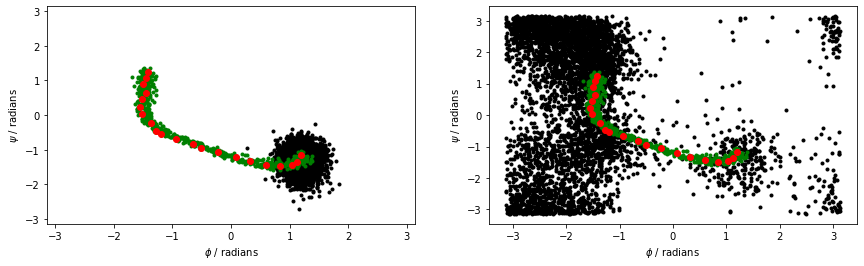

In [40]:
fig, ax = plt.subplots( 1, 2 )
plt.subplots_adjust( right=2  )
ax[0].plot( lowT_data[:,1], lowT_data[:,2], 'k.' )
ax[0].plot( phiv, psiv, 'g.')
ax[0].set_xlim([-np.pi,np.pi])
ax[0].set_ylim([-np.pi,np.pi])
ax[0].plot( phiv2, psiv2, 'ro')
ax[0].set_xlabel(r"$\phi$ / radians")
ax[0].set_ylabel(r"$\psi$ / radians")
ax[1].plot( highT_data[:,1], highT_data[:,2], 'k.' )
ax[1].plot( phiv, psiv, 'g.')
ax[1].plot( phiv2, psiv2, 'ro')
ax[1].set_xlabel(r"$\phi$ / radians")
ax[1].set_ylabel(r"$\psi$ / radians")
plt.savefig("masterclass-21-6-path-angles.png", bbox_inches='tight')
#plt.plot()

And the plot of the path collective variables

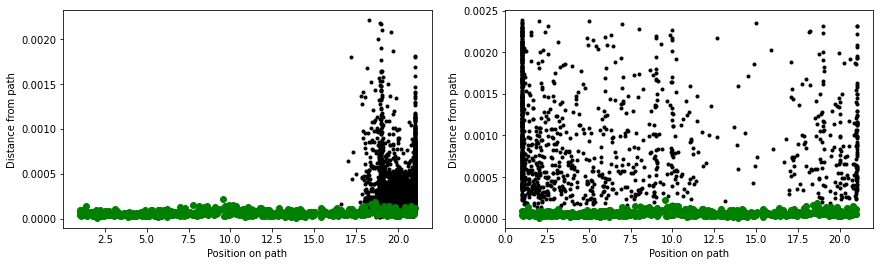

In [41]:
fig, ax = plt.subplots( 1, 2 )
plt.subplots_adjust( right=2  )
ax[0].plot( lowT_data[:,4], lowT_data[:,3], 'k.' )
ax[0].plot( svals, zvals, 'go')
ax[0].set_xlabel('Position on path')
ax[0].set_ylabel('Distance from path')
ax[1].plot( highT_data[:,4], highT_data[:,3], 'k.' )
ax[1].plot( svals, zvals, 'go')
ax[1].set_xlabel('Position on path')
ax[1].set_ylabel('Distance from path')
plt.savefig("masterclass-21-6-path-path.png", bbox_inches='tight')
#plt.show()

# The isocommittor

Lets now run a large number of gromacs simulations that each start from near the configurations in startpoint.pdb and find whether they move to the C7ax basin or the C7eq basin first.  

This is the plumed input we are going to use:

In [42]:
p = '''phi: TORSION ATOMS=5,7,9,15
       psi: TORSION ATOMS=7,9,15,17
       pca: PCAVARS REFERENCE=../data/pca-reference.pdb TYPE=OPTIMAL
       path: PATHMSD REFERENCE=../data/alanine-path.pdb LAMBDA=15100.
       PRINT ARG=phi,psi,pca.eig-1,path.sss FILE=colvar STRIDE=1
       COMMITTOR ARG=phi STRIDE=1 BASIN_LL1=-3 BASIN_UL1=-1 BASIN_LL2=1 BASIN_UL2=2 FILE=basin
'''

And now lets actually use this to generate a trajectory

In [43]:
def gen_trajectories( ntraj, plm ) : 
    nc7eq, c7eq_colv, all_data = 0, np.zeros([0,5]), np.zeros([0,5])
    for i in range(ntraj) :
        !rm -rf ../Test && mkdir ../Test
        generate_gromacs_input( '../Test', plm, 10000000, 300 )
        !cd ../Test/ && gmx_mpi grompp -f md.mdp -c conf.pdb -p topol.top -maxwarn 2 &> /dev/null 
        !cd ../Test/ && gmx_mpi mdrun --plumed plumed.dat &> /dev/null
        bfile = open('../Test/basin','r')
        with open( '../Test/basin', "r" ) as myfile :
            for line in myfile :
                if line.startswith("#! SET COMMITTED TO BASIN") : basin = line.split()[5]
        colv_data = np.loadtxt("../Test/colvar")
        if len(colv_data.shape)==1 : colv_data = np.reshape( colv_data, (1,5) )
        all_data = np.concatenate( (all_data, colv_data), axis=0 )
        if basin=="1" : 
            c7eq_colv = np.concatenate( (c7eq_colv, colv_data), axis=0 )
            nc7eq = nc7eq + 1
    print( "NUMBER c7ax", ntraj-nc7eq, "c7eq", nc7eq )
    return c7eq_colv, all_data

def histo( data, nbins, xmin, xmax ) :
    delr = ( xmax - xmin ) / nbins 
    hist = np.zeros(nbins)
    for d in data : 
        xbin = int( np.floor( (d-xmin) / delr ) )
        hist[xbin] = hist[xbin] + 1
    return hist / delr 

def get_isocommitor( bas_data, full_data, nbins, xmin, xmax ) :
    bas_histo = histo( bas_data, nbins, xmin, xmax ) 
    full_histo = histo( full_data, nbins, xmin, xmax )
    for i in range(nbins) : 
        if np.abs(full_histo[i])<1E-4 : bas_histo[i] = 0 
        else : bas_histo[i] = bas_histo[i] / full_histo[i]
    return bas_histo 

In [44]:
ntraj, nbins, nresamples = 500, 30, 10
avcomm, avcomm2, avhisto, avhisto2 = np.zeros([4,nbins]), np.zeros([4,nbins]), np.zeros([4,nbins]), np.zeros([4,nbins])
for i in range(nresamples) : 
    bas_data, all_data = gen_trajectories( ntraj, p )
    for k in range(1,5) : 
        xmin, xmax = -np.pi, np.pi
        if k==3 : xmin, xmax = -0.15, 0.15
        elif k==4 : xmin, xmax = 0, 22 
        commit = get_isocommitor( bas_data[:,k],  all_data[:,k], nbins, xmin, xmax )
        avcomm[k-1,:] = avcomm[k-1,:] + commit
        avcomm2[k-1,:] = avcomm2[k-1,:] + commit*commit
        histog = histo( all_data[:,k], nbins, xmin, xmax ) / len(all_data)
        avhisto[k-1,:] = avhisto[k-1,:] + histog
        avhisto2[k-1,:] = avhisto2[k-1,:] + histog*histog
    
avcomm = avcomm / nresamples 
avcomm2 = np.sqrt( (nresamples/(nresamples-1))*( avcomm2 / nresamples - avcomm*avcomm ) )
avhisto = avhisto / nresamples 
ahisto2 = np.sqrt( (nresamples/(nresamples-1))*( avhisto2 / nresamples - avhisto*avhisto ) / nresamples )



NUMBER c7ax 291 c7eq 209
NUMBER c7ax 285 c7eq 215
NUMBER c7ax 281 c7eq 219
NUMBER c7ax 286 c7eq 214
NUMBER c7ax 302 c7eq 198
NUMBER c7ax 274 c7eq 226
NUMBER c7ax 307 c7eq 193
NUMBER c7ax 275 c7eq 225
NUMBER c7ax 295 c7eq 205
NUMBER c7ax 274 c7eq 226


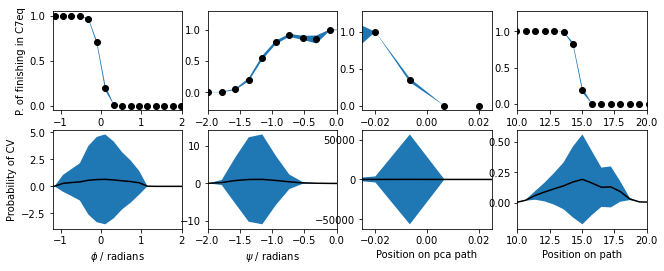

In [45]:
xv, xv2, xv3 = np.zeros(nbins), np.zeros(nbins), np.zeros(nbins)
for i in range(nbins) : 
    xv[i] = -np.pi + (i+0.5)*2*np.pi / nbins
    xv2[i] = -0.2 + (i+0.5)*0.4 / nbins
    xv3[i] =(i+0.5)*22 / nbins
    
fig, ax = plt.subplots( 2, 4 )
plt.subplots_adjust(right=1.5)
for i in range(4) : 
    xvals = xv 
    if i==2 : xvals = xv2
    elif i==3 : xvals = xv3
    ax[0,i].fill_between( xvals, avcomm[i,:]+avcomm2[i,:], avcomm[i,:]-avcomm2[i,:] )
    ax[0,i].plot( xvals, avcomm[i,:], 'ko' )
    ax[1,i].fill_between( xvals, avhisto[i,:]+avhisto2[i,:], avhisto[i,:]-avhisto2[i,:] )
    ax[1,i].plot( xvals, avhisto[i,:], 'k-' )
ax[1,0].set_xlabel(r"$\phi$ / radians")
ax[0,0].set_xlim(-1.2,2)
ax[1,0].set_xlim(-1.2,2)
ax[0,0].set_ylabel("P. of finishing in C7eq")
ax[0,1].set_xlim(-2,0.)
ax[1,1].set_xlim(-2,0.)
ax[1,1].set_xlabel(r"$\psi$ / radians")
ax[1,2].set_xlabel("Position on pca path")
ax[0,2].set_xlim(-0.025,0.025)
ax[1,2].set_xlim(-0.025,0.025)
ax[1,3].set_xlabel("Position on path")
ax[1,0].set_ylabel("Probability of CV")
ax[0,3].set_xlim(10,20)
ax[1,3].set_xlim(10,20)
plt.savefig("masterclass-21-6-committor.png", bbox_inches='tight')
#plt.show()